# DeepPolyLane
#### Lane detection expressed as a regression problem rather than a semantic classification.

Instead of representing lane lines as lit-up pixels in the output activations of a semantic segmentation CNN, the predictions of this CNN are polynomial coefficients (representing lane lines), their bounds and a set existence probablities. This was loosely inspired from YOLOv1, therefore you could argue that instead of dividing the image space into NxN grids and predicting bounding-box coordinates, this network divides the image space into vertical regions and outputs polynomial coefficients of the lane lines. My hypothesis is that it would remove a bulk of the convolution and de-convolution steps, which are expensive operations for embedded devices.

The motivation behind this CNN is to be able to run lane detection on one of my cheap edge AI boards, like Jetson Nano, preferably near real-time. 

Let's see!

In [1]:
# Load the files linked to the dataset and parse them

dataset_files = ['tusimple/train_set/label_data_0313.json', \
                 'tusimple/train_set/label_data_0531.json', \
                 'tusimple/train_set/label_data_0601.json']
json_lines = []
# read all the json strings from the file list
for filename in dataset_files:
    json_dataset_file = open(filename, 'r')
    json_lines.append(json_dataset_file.readlines())
# concat all the json lines into one list of newline-terminated strings
json_lines = [ line for file_lines in json_lines for line in file_lines ]

In [2]:
# randomize the new-line terminated strings.
import random
random.shuffle(json_lines)

%matplotlib inline

# watch for any changes and re-load it automatically
%load_ext autoreload
%autoreload 2

#### Setup the training and validation data loaders

In [17]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from load_data import TUSimpleLaneDataset
from load_data import Normalize, Rescale, ReorderLanes, ToTensor, NormalizeImageNet

from utilities import visualize_detections
import matplotlib.pyplot as plt

# define the transformation steps applied when loading each example
data_transforms = transforms.Compose([ \
                                      Rescale((224, 224)), \
                                      ReorderLanes(), \
                                      Normalize(), \
                                      ToTensor(), \
                                      NormalizeImageNet()])

In [4]:
# create a training dataset object, except the last n_valid data points
n_valid = 100
training_dataset = TUSimpleLaneDataset(json_lines[:-n_valid], 'tusimple/train_set/', data_transforms)

# create a test dataset object out the last 100 images in the list.
validation_dataset = TUSimpleLaneDataset(json_lines[-n_valid:], 'tusimple/train_set/', data_transforms)

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = training_dataset[i]
    print(sample['image'].size(), sample['detections'].size())

torch.Size([3, 224, 224]) torch.Size([7, 5])
torch.Size([3, 224, 224]) torch.Size([7, 5])
torch.Size([3, 224, 224]) torch.Size([7, 5])
torch.Size([3, 224, 224]) torch.Size([7, 5])


In [5]:
# Create a training data loader
train_batch_len = 8
train_loader = DataLoader(training_dataset, batch_size=train_batch_len, shuffle=True, num_workers=0)

In [6]:
# Create a validation data loader
val_batch_len = 8
val_loader = DataLoader(training_dataset, batch_size=val_batch_len, shuffle=True, num_workers=0)

img shape: torch.Size([8, 3, 224, 224]), dtectn shape: torch.Size([8, 7, 5])
batch_size: 8


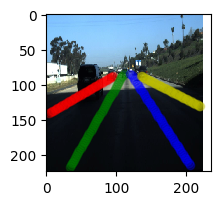

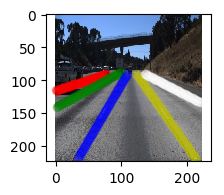

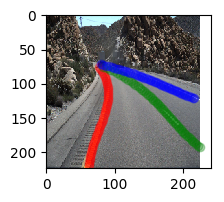

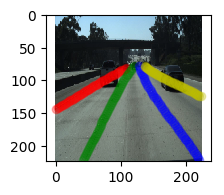

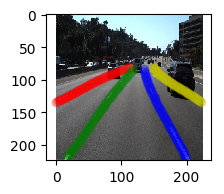

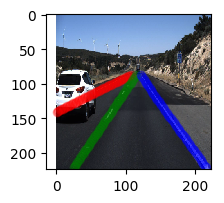

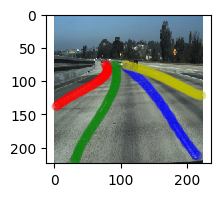

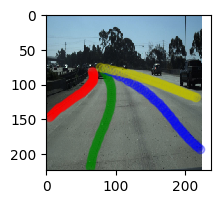

In [32]:
samples = []
for i, sample in enumerate(val_loader):
    samples.append(sample)
    if i == 0:
        break
for sample in samples:
    img = sample['image']
    dtections = sample['detections']
    print('img shape: {}, dtectn shape: {}'.format(img.size(), dtections.size()))
    visualize_detections(img, dtections)

In [8]:
from models import PolyNet

In [9]:
import sys
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
net = PolyNet()
net = net.to(device)

img shape: torch.Size([8, 3, 224, 224]), dtectn shape: torch.Size([8, 7, 5])
existence shape:  torch.Size([8, 1, 5])
geo_shape:  torch.Size([8, 6, 5])
pred shape:  torch.Size([8, 7, 5])
batch_size: 8
----------------------------------------
coeff: [-0.48868778  0.7304137  -2.11253501  1.11606156], bounds: [ 0.40277778  0.59722222]
coeff: [-0.00855754  0.01695855 -0.64036397  0.69668468], bounds: [ 0.38888889  0.98611111]
coeff: [-0.00222197  0.00462911  0.77539719  0.19676021], bounds: [ 0.41666667  0.97222222]
coeff: [ 0.16993007 -0.29333167  2.29070773 -0.34684495], bounds: [ 0.44444444  0.61111111]
----------------------------------------


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


coeff: [ 14.87773712 -23.41927848  10.79549149  -1.23530891], bounds: [ 0.36111111  0.61111111]
coeff: [ 1.53871487 -3.42613748  2.12539718 -0.02131935], bounds: [ 0.34722222  0.98611111]
coeff: [ 1.49056752 -3.25912146  3.1700392  -0.36195768], bounds: [ 0.34722222  0.95833333]
coeff: [ 11.05913313 -17.10487616  10.86944176  -1.73691346], bounds: [ 0.34722222  0.58333333]
----------------------------------------
coeff: [ 0.00698953 -0.01442978 -0.63597367  0.72347945], bounds: [ 0.36111111  0.98611111]
coeff: [ 0.01539541 -0.03317962  0.64181373  0.31360618], bounds: [ 0.33333333  0.98611111]
coeff: [ 0.0501548  -0.08202399  1.86689967 -0.05081431], bounds: [ 0.33333333  0.55555556]
----------------------------------------
coeff: [ 0.00683929 -0.01773602 -1.74662345  1.08671398], bounds: [ 0.36111111  0.61111111]
coeff: [-0.00206393  0.00364578 -0.63100805  0.73082495], bounds: [ 0.36111111  0.98611111]
coeff: [ 0.00213069 -0.00411419  0.70968013  0.2799711 ], bounds: [ 0.36111111  0.

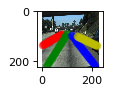

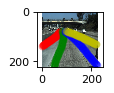

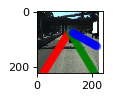

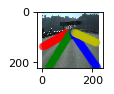

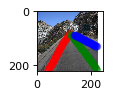

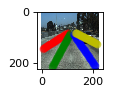

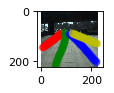

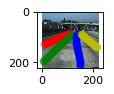

batch_size: 8
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------


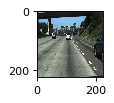

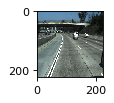

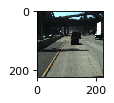

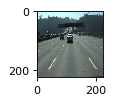

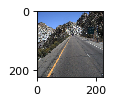

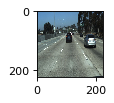

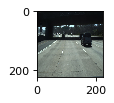

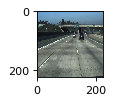

In [10]:
samples = []
for i, sample in enumerate(val_loader):
    samples.append(sample)
    if i == 0:
        break
for sample in samples:
    img = sample['image']
    dtections = sample['detections']
    print('img shape: {}, dtectn shape: {}'.format(img.size(), dtections.size()))
    existence, geo = net(img.type(torch.FloatTensor).to(device))
    existence = existence.view(-1, 1, 5).cpu()
    geo = geo.view(-1, 6, 5).cpu()
    print('existence shape: ', existence.shape)
    print('geo_shape: ', geo.shape)
    predicted_dtectn = torch.cat([existence, geo], dim=1)
    print('pred shape: ', predicted_dtectn.shape)
    visualize_detections(img, dtections)
    visualize_detections(img, predicted_dtectn)

In [11]:
'''
The lane_line_loss() takes a pair of tensor of size (batches, 7, 5), of which the first rows are existence scores of
of the respective lane-lines and the rest are polynomial coefficients and bounds.
'''
num_lines = 5
def lane_line_loss(predicted, ground_truth):
    # reshape tensors into appropriate sizes
    
    ground_truth = ground_truth.view(-1, 7, num_lines)
    expected_existence = ground_truth[:, 0, :].view(-1, num_lines)
    expected_geometry = ground_truth[:, 1:, :]
    
    pred_existence, pred_geometry = predicted
    pred_existence = pred_existence.view(-1, num_lines)
    pred_geometry = pred_geometry.view(-1, 6, num_lines)
    
    # Compute existence loss
    existence_criteria = torch.nn.BCELoss()
    existence_loss = existence_criteria(pred_existence, expected_existence)
    
    n_batch = pred_geometry.shape[0]
    
    # Compute weighted smooth L1 loss. The weight is either 0 or 1, depending whether the line exists or not
    geometry_loss = 0
    for i in range(n_batch):
        for j in range(num_lines):
            weight = expected_existence[i,j]
            residual = expected_geometry[i, :, j] - pred_geometry[i, :, j]
            norm = torch.norm(residual)
            if norm < 1.0:
                geometry_loss += 0.5 * norm * norm * weight
            else:
                geometry_loss += (norm - 0.5) * weight
                
    geometry_loss /= n_batch
    
    return (existence_loss, geometry_loss)
    

### Training 
Time to scorch them GPUs!

In [12]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)

In [13]:
model_dir = 'saved_models/'
model_name = 'polynet1.pt'

def train_net(n_epochs):
    n_train = len(train_loader.dataset)
    n_test = len(val_loader.dataset)
    best_eval_loss = 10000000000.0
    
    # Store the losses for plotting.
    train_losses = []
    eval_losses = []
    
    for epoch in range(n_epochs):
        net.train()
        running_loss = 0.0
        train_loss = 0
        
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            gt = data['detections']
            
            images = images.type(torch.FloatTensor).to(device)
            gt = gt.type(torch.FloatTensor).to(device)
            
            predictions = net(images)
        
            existence_loss, geometry_loss = lane_line_loss(predictions, gt)    
            loss = existence_loss + geometry_loss
            optimizer.zero_grad() # zero the parameter (weight) gradients
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            train_loss += loss.item()
            if batch_i % 10 == 0:    # print every 10 batches
                print('Epoch: {}, {}/{}, Avg. Loss: {}'.format(epoch + 1, (batch_i + 1) * train_batch_len, n_train, running_loss/(10 * train_batch_len)), end='\r')
                running_loss = 0.0

        train_loss /= n_train
        train_losses.append(train_loss)
        print('\nEpoch {}, training loss: {}'.format(epoch + 1, train_loss))
        
        '''
        -------------------
        '''
        
        # evaluate the network performance at the end of every epoch.
        print('\nEvaluating...')
        net.eval()
        eval_loss = 0
        for batch_i, data in enumerate(val_loader):
            # get the input image and their labels
            
            images = data['image']
            gt = data['detections']
            
            images = images.type(torch.FloatTensor).to(device)
            gt = gt.type(torch.FloatTensor).to(device)
            
            predictions = net(images)
        
            existence_loss, geometry_loss = lane_line_loss(predictions, gt)    
            loss = existence_loss + geometry_loss
            eval_loss += loss.item() 
        eval_loss = eval_loss / n_test
        eval_losses.append(eval_loss)
        print('Epoch:{} Avg Eval Loss: {}'.format(epoch + 1, eval_loss))
        
        # save the best performing model
        if(eval_loss < best_eval_loss):
            # after training, save your model parameters in the dir 'saved_models'
            snapshot_name = model_dir+model_name
            print('Saving network: {}'.format(snapshot_name))
            torch.save(net.state_dict(), snapshot_name)
            best_eval_loss = eval_loss
            
        # Plot the training and validation losses.
        plt.clf()
        %matplotlib inline
        plt.grid(True)
        plt.xlim([0, n_epochs])
        plt.plot(train_losses, label = 'training loss')
        plt.plot(eval_losses, label = 'validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
            

In [ ]:
train_net(10)

In [27]:
from utilities import visualize_detections
def sample_predictions():
    samples = []
    for i, sample in enumerate(val_loader):
        samples.append(sample)
        if i == 0:
            break
    
    img = samples[0]['image']
    dtections = samples[0]['detections']
    existence, geo = net(img.type(torch.FloatTensor).to(device))
    existence = existence.view(-1, 1, 5).cpu()
    geo = geo.view(-1, 6, 5).cpu()
    predicted_dtectn = torch.cat([existence, geo], dim=1)
    visualize_detections(img, predicted_dtectn)

In [ ]:
sample_predictions()